In [7]:
from dotenv import load_dotenv

env_loaded = load_dotenv("../packages/sdk/.env")

if not env_loaded:
    raise Exception("Failed to load .env file")

In [8]:
import os
from supabase import create_client
from githubkit import GitHub

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
github = GitHub(GITHUB_TOKEN)

In [9]:
from typing import Dict, Optional
from datetime import datetime
from githubkit.exception import RequestFailed
from time import sleep

MAX_RETRIES = 5
ETH_GLOBAL_SF_START = datetime(2024, 10, 18, 0, 0, 0)
ETH_GLOBAL_SF_END = datetime(2024, 10, 20, 23, 59, 59)


def get_commits_for_repo(owner: str, name: str) -> Optional[int]:
    try:
        return len(
            [
                commit
                for commit in github.paginate(
                    github.rest.repos.list_commits,
                    owner=owner,
                    repo=name,
                    since=ETH_GLOBAL_SF_START,
                    until=ETH_GLOBAL_SF_END,
                )
            ]
        )
    except RequestFailed as exception:
        if exception.response.status_code == 404:
            return None
        raise exception


def get_issues_for_repo(owner: str, name: str) -> Optional[int]:
    try:
        all_issues = [
            issue
            for issue in github.paginate(
                github.rest.issues.list_for_repo,
                owner=owner,
                repo=name,
                since=ETH_GLOBAL_SF_START,
            )
        ]
        valid_issues = list(
            filter(
                lambda issue: ETH_GLOBAL_SF_START.timestamp()
                <= issue.created_at.timestamp()
                <= ETH_GLOBAL_SF_END.timestamp(),
                all_issues,
            )
        )
        return len(valid_issues)
    except RequestFailed as exception:
        if exception.response.status_code == 404:
            return None
        raise exception


def get_pull_requests_for_repo(owner: str, name: str) -> Optional[int]:
    try:
        all_prs = [
            pr
            for pr in github.paginate(
                github.rest.pulls.list,
                owner=owner,
                repo=name,
                state="all",
            )
        ]
        valid_all_prs = list(
            filter(
                lambda pr: ETH_GLOBAL_SF_START.timestamp()
                <= pr.created_at.timestamp()
                <= ETH_GLOBAL_SF_END.timestamp(),
                all_prs,
            )
        )
        return len(valid_all_prs)
    except RequestFailed as exception:
        if exception.response.status_code == 404:
            return None
        raise exception


def get_code_frequency_for_repo(
    owner: str, name: str, retries=MAX_RETRIES
) -> Optional[Dict[str, int]]:
    if retries <= 0:
        return None

    try:
        freq = github.rest.repos.get_code_frequency_stats(owner, name)
        if freq.status_code == 202:
            sleep(10)
            print(
                "-- Code frequency stats not available for %s/%s, retrying... (%d/%d)"
                % (owner, name, MAX_RETRIES + 1 - retries, MAX_RETRIES)
            )
            return get_code_frequency_for_repo(owner, name, retries - 1)

        data = freq.json()
        valid_days = list(
            filter(
                lambda x: ETH_GLOBAL_SF_START.timestamp()
                <= x[0]
                <= ETH_GLOBAL_SF_END.timestamp(),
                data,
            )
        )
        if len(valid_days) == 0:
            return None

        return {
            "additions": sum([x[1] for x in valid_days]),
            "deletions": abs(sum([x[2] for x in valid_days])),
        }

    except RequestFailed as exception:
        if exception.response.status_code == 404:
            return None
        raise exception


def get_repo_stats(owner: str, name: str) -> Optional[Dict[str, int]]:
    commits = get_commits_for_repo(owner, name)
    issues = get_issues_for_repo(owner, name)
    prs = get_pull_requests_for_repo(owner, name)
    code_freq = get_code_frequency_for_repo(owner, name)

    return {
        "commits": commits if commits is not None else 0,
        "issues": issues if issues is not None else 0,
        "pull_requests": prs if prs is not None else 0,
        "additions": code_freq["additions"] if code_freq is not None else 0,
        "deletions": code_freq["deletions"] if code_freq is not None else 0,
    }

In [10]:
import json
from typing import List

THE_GRINDERS_FUND_POOL_ID = "7fa41451-a565-4fa0-a851-f47ce20ce40b"

grinders_pool = (
    supabase.from_("pool_registrations")
    .select("*")
    .eq("pool_id", THE_GRINDERS_FUND_POOL_ID)
    .execute()
)


def load_all_data() -> List[Dict]:
    all_data = []

    if os.path.exists("grinders_fund_data.json"):
        with open("grinders_fund_data.json", "r") as f:
            return json.load(f)

    total_entries = len(grinders_pool.data)

    for idx, entry in enumerate(grinders_pool.data, start=1):
        artifact_name = entry.get("artifact_name")
        artifact_namespace = entry.get("artifact_namespace")
        print(
            f"@@ Processing {idx}/{total_entries} ({artifact_namespace}/{artifact_name})"
        )

        if any(
            entry["artifact"] == f"{artifact_namespace}/{artifact_name}"
            for entry in all_data
        ):
            print(f"%% Skipping {artifact_namespace}/{artifact_name}, already processed")
            continue

        repo_stats = get_repo_stats(artifact_namespace, artifact_name)
        if repo_stats is None:
            print(f"^^ Failed to get stats for {artifact_namespace}/{artifact_name}")
            continue

        all_data.append(
            {
                "artifact": f"{artifact_namespace}/{artifact_name}",
                **repo_stats,
            }
        )

    with open("grinders_fund_data.json", "w") as f:
        json.dump(all_data, f)

    return all_data

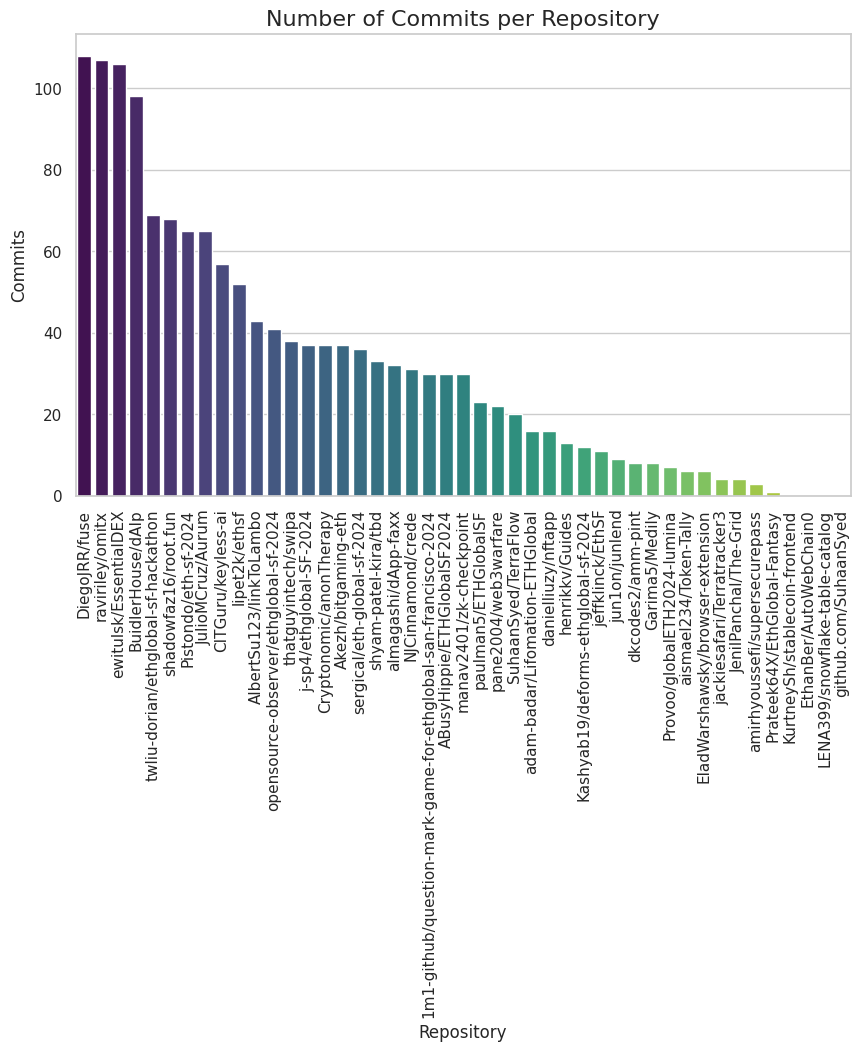

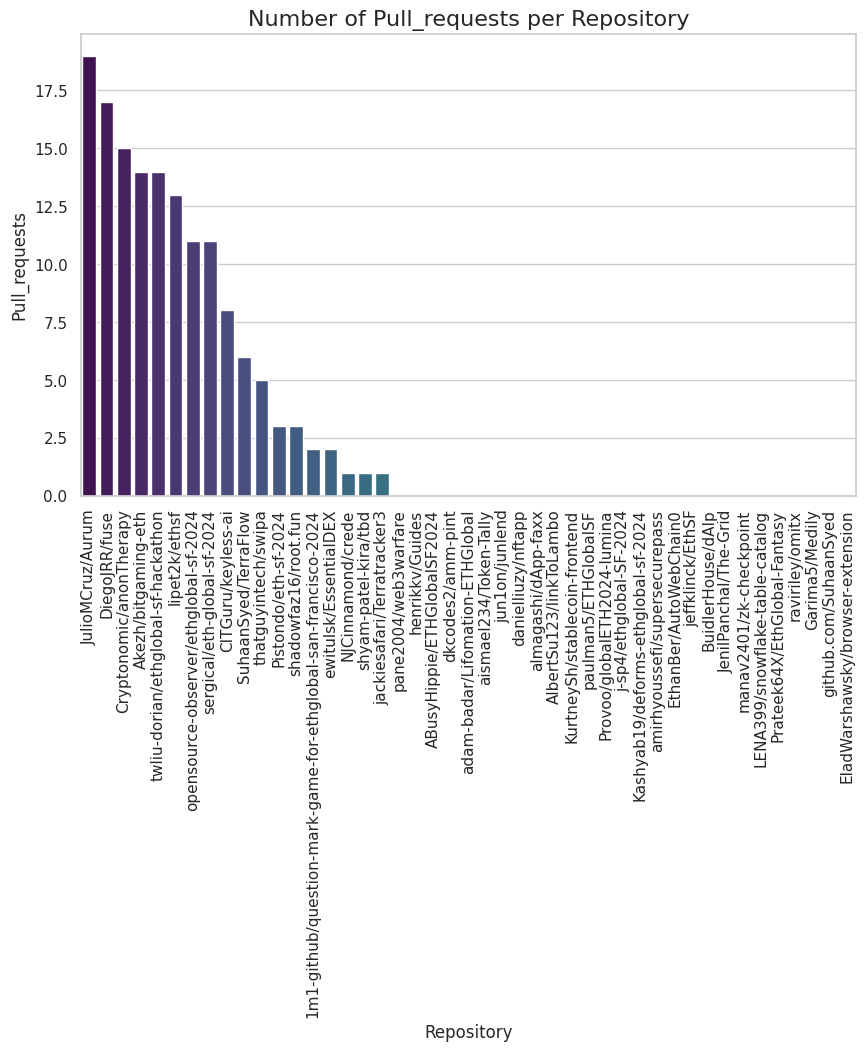

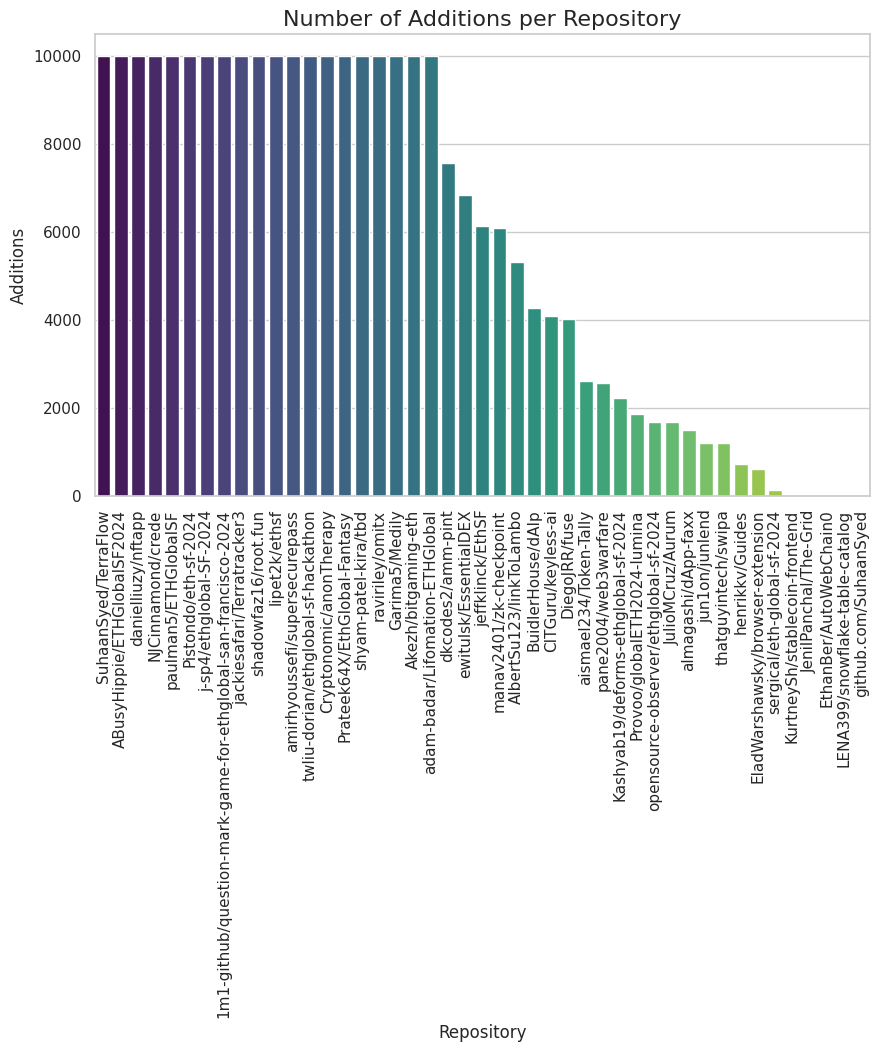

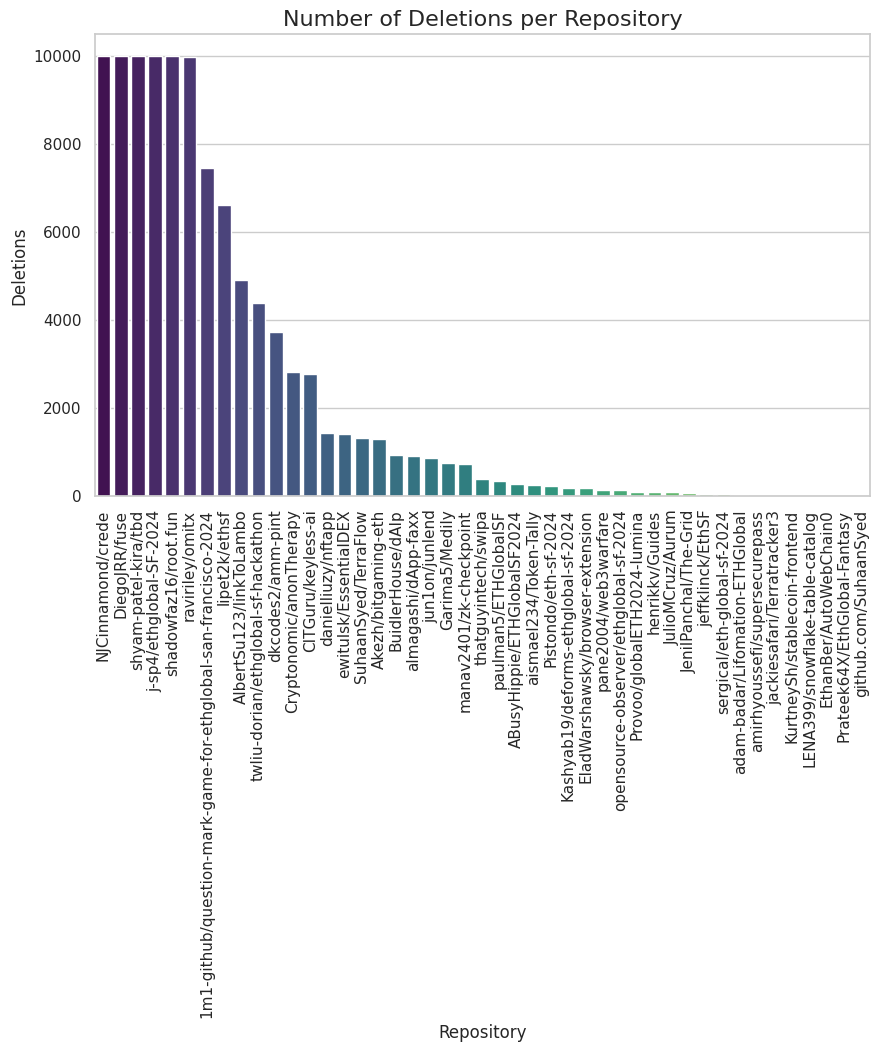

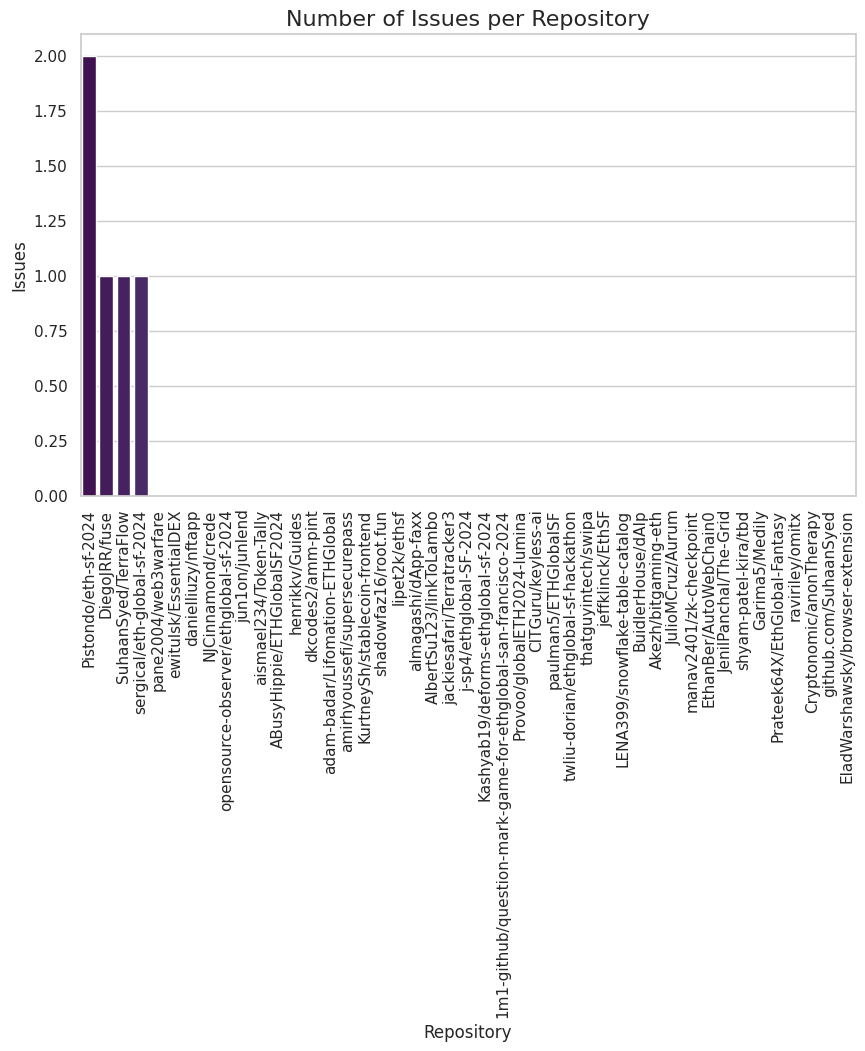

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(load_all_data())

sns.set_theme(style="whitegrid")


def plot_metric(df: pd.DataFrame, metric: str, title: str):
    sorted_df = df.sort_values(by=metric, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="artifact",
        y=metric,
        data=sorted_df,
        hue="artifact",
        palette="viridis",
        dodge=False,
        legend=False,
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Repository", fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xticks(rotation=90)
    plt.show()


plots = ["commits", "pull_requests", "additions", "deletions", "issues"]

for plot in plots:
    if plot in ["additions", "deletions"]:
        df[plot] = df[plot].apply(lambda x: min(x, 10_000))

    plot_metric(df, plot, f"Number of {plot.capitalize()} per Repository")

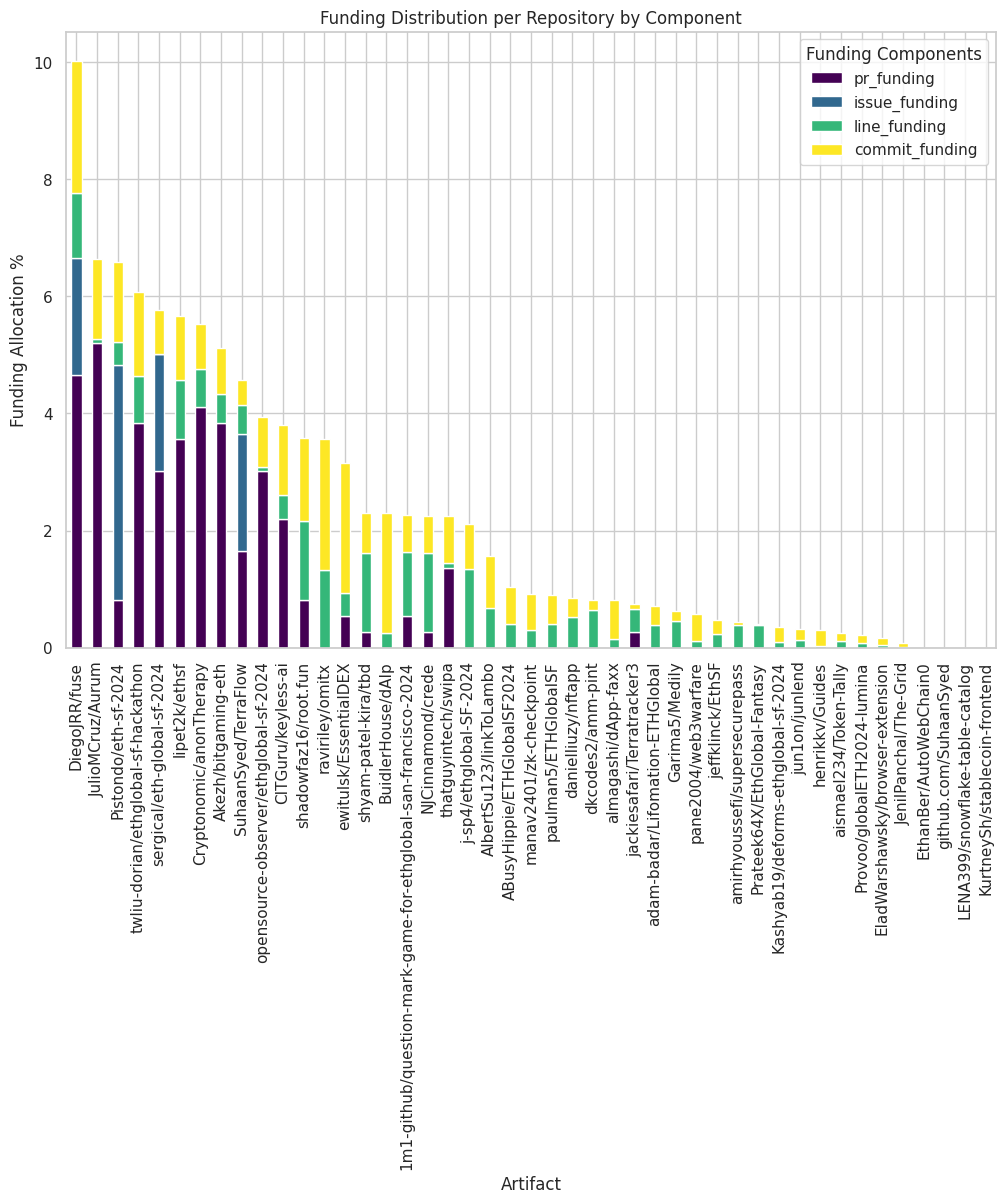

In [12]:
PR_WEIGHT = 0.4
ISSUE_WEIGHT = 0.1
LINES_WEIGHT = 0.2
COMMIT_WEIGHT = 0.3
FUNDING_POOL = 100


def cap_lines(lines: int) -> int:
    return min(lines, 10_000)


def calculate_normalized_metrics(df: pd.DataFrame) -> pd.DataFrame:
    totals = {
        "pull_requests": df["pull_requests"].sum(),
        "issues": df["issues"].sum(),
        "lines_added": df["additions"].apply(cap_lines).sum(),
        "lines_deleted": df["deletions"].apply(cap_lines).sum(),
        "commits": df["commits"].sum(),
    }

    df["normalized_prs"] = df["pull_requests"] / totals["pull_requests"]
    df["normalized_issues"] = df["issues"] / totals["issues"]
    df["normalized_lines_added"] = (
        df["additions"].apply(cap_lines) / totals["lines_added"]
    )
    df["normalized_lines_deleted"] = (
        df["deletions"].apply(cap_lines) / totals["lines_deleted"]
    )
    df["normalized_commits"] = df["commits"] / totals["commits"]
    df["normalized_lines"] = (
        df["normalized_lines_added"] + df["normalized_lines_deleted"]
    ) / 2

    return df


def calculate_funding_distribution(df: pd.DataFrame) -> pd.DataFrame:
    df["pr_funding"] = FUNDING_POOL * PR_WEIGHT * df["normalized_prs"]
    df["issue_funding"] = FUNDING_POOL * ISSUE_WEIGHT * df["normalized_issues"]
    df["line_funding"] = FUNDING_POOL * LINES_WEIGHT * df["normalized_lines"]
    df["commit_funding"] = FUNDING_POOL * COMMIT_WEIGHT * df["normalized_commits"]

    df["allocated_funding"] = (
        df["pr_funding"]
        + df["issue_funding"]
        + df["line_funding"]
        + df["commit_funding"]
    )

    funding_distribution = (
        df.groupby("artifact", as_index=False)[
            [
                "allocated_funding",
                "pr_funding",
                "issue_funding",
                "line_funding",
                "commit_funding",
            ]
        ]
        .sum()
        .round(4)
        .sort_values(by="allocated_funding", ascending=False)
    )

    return funding_distribution


def plot_funding_distribution_with_composition(df: pd.DataFrame, title: str):
    df.set_index("artifact")[
        ["pr_funding", "issue_funding", "line_funding", "commit_funding"]
    ].plot(kind="bar", stacked=True, figsize=(12, 8), colormap="viridis")
    plt.title(title)
    plt.xlabel("Artifact")
    plt.ylabel("Funding Allocation %")
    plt.legend(title="Funding Components")
    plt.show()


metrics_df = calculate_normalized_metrics(df)
funding_distribution_df = calculate_funding_distribution(metrics_df)


plot_funding_distribution_with_composition(
    funding_distribution_df, "Funding Distribution per Repository by Component"
)